![Py4Eng](img/logo.png)

# Cython
## Yoav Ram

# Cython at a glance

[Cython](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance) is a compiler which compiles Python-like code files to C code. Still, ‘’Cython is not a Python to C translator’‘. That is, it doesn’t take your full program and “turns it into C” – rather, the result makes full use of the Python runtime environment. A way of looking at it may be that your code is still Python in that it runs within the Python runtime environment, but rather than compiling to interpreted Python bytecode one compiles to native machine code (but with the addition of extra syntax for easy embedding of faster C-like code).

This has two important consequences:

- **Speed.** How much depends very much on the program involved though. Typical Python numerical programs would tend to gain very little as most time is spent in lower-level C that is used in a high-level fashion. However for-loop-style programs can gain many orders of magnitude, when typing information is added (and is so made possible as a realistic alternative).
- **Easy calling into C code.** One of Cython’s purposes is to allow easy wrapping of C libraries. When writing code in Cython you can call into C code as easily as into Python code.

Some Python constructs are not yet supported, though making Cython compile all Python code is a stated goal (among the more important omissions are inner functions and generator functions).

# Hello world!

Let's start with a simple *Hello World!* to check that everything is working.

We load the `Cython` magic that will allow us to quickly use Cython inside the notebook. The magic is installed with the `cython` package (`conda install cython` or `pip install cython`). The Cython requires that a C compiler is installed and can be found, and on Windows that may be tricky, here are some resources:

- [Install Cython on Windows](https://github.com/cython/cython/wiki/InstallingOnWindows)
- [Install C compiler on Windows](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows)
- [Compiling Python extensions on Windows](https://blog.ionelmc.ro/2014/12/21/compiling-python-extensions-on-windows/)

On Linux/OSX you probably already have a compiler, check with `!gcc --version`. If `gcc` is not found, install it:

- On [Ubuntu](https://help.ubuntu.com/community/InstallingCompilers) you should run `sudo apt-get install build-essential`.
- On CentOS you just need to install development tools: `sudo yum group install "Development Tools"`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import Cython
print("Cython", Cython.__version__)

%load_ext Cython

Cython 0.28.1


In [2]:
%%cython 
print("Hello World!")

Hello World!


# First Cython example

Let's see a quick example of what Cython can do for us. 

Consider the following Python [function that returns the first k prime numbers](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html) (but not more than 1000):

In [16]:
def find_k_primes(k):
    primes = [None] * 1000
    n_primes = 0  # the current number of elements in p.
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return primes[:n_primes]

In [17]:
assert find_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Here is the Cython version of this function; the only addition here is that we use `cdef` to define the types of `n, k, i, p`. This `cdef` statement is used to define **local C variables**. We also add `int` in the arguments list to define the type of `kmax`: this means that any object passed will be **converted to a C integer**.

In [22]:
%%cython
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  # the current number of elements in p.
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return [p for p in primes[:n_primes]]

In [19]:
find_k_primes(100) == cfind_k_primes(100)

True

In [20]:
n = 1000
%timeit find_k_primes(n)
%timeit cfind_k_primes(n)

36.1 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.51 ms ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Note that in the inner loop only variables with type definitions, and thus C objects, are reffered to; therefore, the loop is translated to a C loop, and runs very fast.

# Creating a Cython module

We can now put that Cython code into a separate file with extension `pyx`. 

In [23]:
!mkdir ../scripts/cython
%cd ../scripts/cython

mkdir: ../scripts/cython: File exists
/Users/yoavram/Work/Py4Eng/scripts/cython


In [24]:
%%file primes.pyx
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  # the current number of elements in p.
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return [p for p in primes[:n_primes]]

Overwriting primes.pyx


Now we compile it and import it with a single stroke using the [`pyximport` module](http://docs.cython.org/en/latest/src/reference/compilation.html#pyximport),

> Cython code, unlike Python, must be compiled.
> This happens in two stages:
> A .pyx file is compiles by Cython to a .c file.
> The .c file is compiled by a C comiler to a .so file (or a .pyd file on Windows)

In [25]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x10b6ab358>)

In [21]:
from primes import cfind_k_primes

In [26]:
len(cfind_k_primes(100)) == 100

True

You can also do this on your own, without `pyximport`. This is useful when shipping or if you just want to see the C file - for example, to see how much work Cython saved you from doing!

You start by writing a `setup.py` file which imports `cythonize` from the Cython package and tells `setup` (the standard way to setup Python packages, using `distutils` or `setuptools`) to build an extension module using `cythonize`.

In [35]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("primes.pyx")
)

Overwriting setup.py


Run it with this command, which builds the extension:

In [39]:
python = os.path.join(sys.base_prefix, 'bin', 'python')
!$python setup.py build_ext --inplace

Compiling primes.pyx because it changed.
[1/1] Cythonizing primes.pyx
running build_ext
building 'primes' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/yoavram/miniconda3/envs/Py4Eng/include -arch x86_64 -I/Users/yoavram/miniconda3/envs/Py4Eng/include -arch x86_64 -I/Users/yoavram/miniconda3/envs/Py4Eng/include/python3.6m -c primes.c -o build/temp.macosx-10.9-x86_64-3.6/primes.o
gcc -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/yoavram/miniconda3/envs/Py4Eng/lib -L/Users/yoavram/miniconda3/envs/Py4Eng/lib -headerpad_max_install_names -Wl,-rpath,/Users/yoavram/miniconda3/envs/Py4Eng/lib -L/Users/yoavram/miniconda3/envs/Py4Eng/lib -headerpad_max_install_names -arch x86_64 build/temp.macosx-10.9-x86_64-3.6/primes.o -L/Users/yoavram/miniconda3/envs/Py4Eng/lib -o /Users/yoavram/Work/Py4Eng/scripts/cython/primes.cpython-36m-darwin.so


Let's see what was generated (this might look different on different machines, especially Windows vs. Linux):

In [40]:
%ls

build/                        primes.pyx
primes.c                      setup.py
primes.cpython-36m-darwin.so* tmp/


And the actual C file:

In [41]:
%less primes.c

You can now import `primes` as if it was a regular Python module (if you aren't sure which of the things you are importing, restart your kernel, but don't forger to change directory to `../scripts/cython`).

In [42]:
import primes

In [43]:
primes.cfind_k_primes(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

# Another example

This is from Robert Bradshaw [SciPy 2008 slides](http://wiki.sagemath.org/scipy08?action=AttachFile&do=get&target=scipy-cython.tgz).

We will write a simple integration code to integrate $f(x) = x^3 - 3x$:

In [44]:
def f(x):
    return x**3 - 3 * x

def integrate_f(a , b , N):
    s = 0
    dx = (b - a )/ N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [45]:
%timeit integrate_f(0, 1, 100000)

30.5 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now, the same with Cython. Note that when we define a function with `cdef` we can set a return value but we can only c
all it from within Cython. When we define a function with `def` we can import it and call it from Python.

Note that we change `x**3` to `x * x * x`.

In [46]:
%%cython
cdef double g(double x):
    return x * x * x - 3* x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a )/ N
    cdef int i
    for i in range(N):
        s += g( a + i * dx )
    return s * dx

In [47]:
%timeit integrate_g(0, 1, 100000)

132 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now let's integrate 
$$
\int_a^b{\frac{\sin{x}}{x}}
$$

Without Cython, we should use either `math.sin` or `numpy.sin`:

In [48]:
def f(x):
    return np.sin(x) / x

integrate_f(1, 2, 100000)

0.6593318405457452

With Cython, we can import some C functions using an `extern` block:

In [49]:
%%cython
cdef extern from "math.h":
    double sin(double)
    double cos(double)

cdef double g(double x):
    return sin(x)/x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a) /  N
    cdef int i
    for i in range(N):
        s += g(a + i * dx)
    return s * dx

In [50]:
%timeit integrate_f(1, 3, 100000)
%timeit integrate_g(1, 3, 100000)

105 ms ± 7.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.23 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Cython + NumPy

Cython works well with NumPy.

Let's loop over a NumPy array:

In [51]:
def summ(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s

In [52]:
%%cython
cimport numpy as np

def csumm(long[:] x):
    cdef np.ndarray[long, ndim=1] arr = x
    cdef int i = 0
    cdef long s = 0
    for i in range(arr.shape[0]):
        s += arr[i]
    return s

In [53]:
x = np.random.randint(0, 9, 100000)
%timeit summ(x)
%timeit csumm(x)

15.5 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
96.1 µs ± 2.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Note that if you would type `s` and `arr` as made of `int` you would get an error because Python's `int` is a C `long`... But you would get a `ValueError`, not a segmentation fault or anything like that. Here's an example:

In [54]:
y = np.array([0.1, 0.2, 0.3])
csumm(y)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

# Example: Mandelbrot fractal

In [3]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [4]:
%%cython

def cmandelbrot(int[:,:] m,
                int size,
                int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100: # note - no use of np.abs
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [6]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)

In [59]:
%timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)

1.65 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.37 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


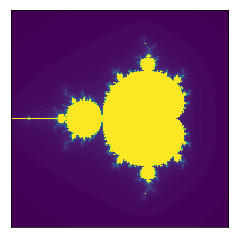

In [61]:
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

# Numba

[Numba]((http://numba.pydata.org) speeds functions written directly in Python. 
With a few annotations, array-oriented and math-heavy Python code can be *just-in-time* (JIT) compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

Roughly, [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) compilation combines the speed of compiled code with the flexibility of interpretation, with the overhead of an interpreter and the additional overhead of compiling (not just interpreting)

In [4]:
import numba
print('Numba', numba.__version__)

Numba 0.37.0


In [64]:
@numba.jit()
def numandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
numandelbrot(m, size, iterations); # run once for jit to work

In [65]:
# %timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)
%timeit numandelbrot(m, size, iterations)

3.39 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise - difference matrix

Write a Cython function that calculates the difference matrix for a given array.
Compare it to the NumPy implementation.

In [10]:
def diff_mat(x):
    return x.reshape(-1, 1) - x

In [95]:
x = np.random.random(10000)
assert np.allclose(diff_mat(x), cdiff_mat(x))
%timeit diff_mat(x)
%timeit cdiff_mat(x)

455 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
496 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You can explore other [compiler directives](https://github.com/cython/cython/wiki/enhancements-compilerdirectives) such as `wraparound` and `nonecheck`.

# Releasing the GIL

Cython can be directed to [release the GIL](http://docs.cython.org/src/userguide/external_C_code.html#acquiring-and-releasing-the-gil), thus enabling multiple threads to run in parallel (if the OS allows it) and achieve performence gain even in comparison to multi-processing, as threads are cheaper than processes and thread communication is faster than process communication.

In [5]:
def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [6]:
%pwd

'/Users/yoavram/Work/Py4Eng/sessions'

Let's do a segmentation demonstration.

(dtype('float64'), (900, 944), 0.0, 255.0)

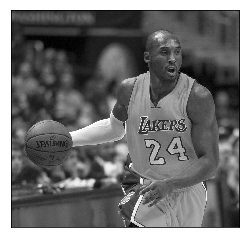

In [7]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
import imageio
image = imageio.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

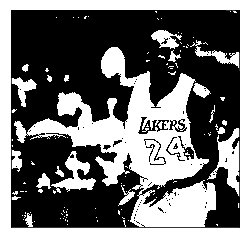

In [8]:
def segment(image, threshold, output=None):
    if output is None:
        output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image, 100))

In [9]:
%%cython
import numpy as np
import cython 

# if you comment this out, cython will warn you to add it for faster access
@cython.boundscheck(False) 
cdef void _segment(double[:,:] image, int n, int m, 
                   double threshold, double[:,:] output) nogil: # note the "nogil" directive
    cdef int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def csegment(image, threshold, output=None):
    if output is None:
        output = np.zeros_like(image)
    n, m = image.shape
    _segment(image, n , m, threshold, output)
    return output

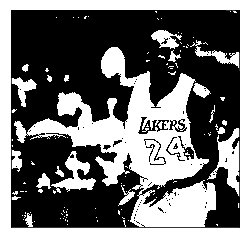

In [10]:
display_image(csegment(image, 100))

In [130]:
%timeit segment(image, 100)
%timeit csegment(image, 100)

2.3 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.64 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So performance on a single image is similar, what about using multi-threading for segmenting a bunch of images?

Let's download the 30 examples images from the [PASCAL VOC 2012 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html).

![example](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/05.jpg)

In [11]:
image_urls = [
    'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/{:02d}.jpg'.format(i)
    for i in range(1,31)
]

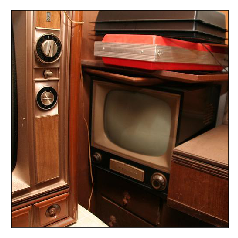

In [63]:
display_image(imageio.imread(image_urls[4]))

Let's load and flatten the images:

In [66]:
images = [imageio.imread(url) for url in image_urls]
images = [im.mean(axis=2) for im in images]

Let's also resize the images so that the segmentation task is harder.
We'll increaes the width and height 8-fold.

In [67]:
from skimage.transform import resize

In [68]:
shapes = [im.shape for im in images]
images = [resize(im, (w*12, h*12), mode='reflect') 
          for im, (w, h) in zip(images, shapes)]

First compare the NumPy and Cython versions:

In [69]:
%timeit [segment(im, 100) for im in images]
%timeit [csegment(im, 100) for im in images]

5.26 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.58 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


No real difference, of course.
Now let's do it with multi-threading, leveraging the `nogil` directive.

In [70]:
from concurrent.futures import ThreadPoolExecutor

def segment_parallel(images, threshold):
    def _segment(im):
        return csegment(im, threshold)
    with ThreadPoolExecutor() as executor:
        results = executor.map(_segment, images)
        return list(results)

In [71]:
%timeit [csegment(im, 100) for im in images]
%timeit segment_parallel(images, 100)

4.86 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.45 s ± 736 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You can look at the process monitor (or `top`/`htop` on Linux/Mac) when the next two cells run to see that the first uses less cores than the latter. 

In [ ]:
for _ in range(10): 
    [csegment(im, 100) for im in images];

In [57]:
for _ in range(10): 
    segment_parallel(images, 100);

# Solutions

Difference Matrix:

In [ ]:
%%cython
cimport numpy as np
import numpy as np
import cython        
        
cdef void _cdiff_mat(double[:] x, int size, double[:,:] output):
    cdef int i, j
    for i in range(size):
        for j in range(size):
            output[i, j] = x[i] - x[j]        

def cdiff_mat(double[:] x):
    size = len(x)
    output = np.empty((size, size))
    _cdiff_mat2(x, size, output)
    return output

# References

- [Cython language basics](http://docs.cython.org/src/userguide/language_basics.html#language-basics)
- [Cython for NumPy users](http://docs.cython.org/src/userguide/numpy_tutorial.html#numpy-tutorial) offers a 2D convolve example.
- [IPython Cookbook](https://ipython-books.github.io/cookbook/) by Cyrille Rossant has a full chapter on high performance computing. with many [notebook examples](https://github.com/ipython-books/cookbook-code/tree/master/notebooks/chapter05_hpc) and a more complicated Cython example.
- [Numba](http://numba.pydata.org/)
- [Numexpr](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide)
- [Blaze Ecosystem](http://blaze.pydata.org/)
- Jake Vanderplas's [Cython project template](https://github.com/jakevdp/cython_template) can help you build projects that use Cython.

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)